<a href="https://colab.research.google.com/github/Mart1Portfolio/ensai-apprentissage-profond/blob/main/notebooks/TP_4_1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [1]:
! pip install lightning torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 63.8 MB/s eta 0:00:00


3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [2]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# *Inpainting* d'images masquées

Dans ce notebook, vous allez travailler sur le jeu de données [MNIST](https://en.wikipedia.org/wiki/MNIST_database) constitué d'images de chiffres manuscrits.

L'[*inpainting*](https://fr.wikipedia.org/wiki/Inpainting) consiste à reconstruire des images détériorées ou à remplir des parties manques des images.
L'exemple ci-dessous est tiré de la page Wikipedia concernant l'*inpainting*.
À gauche se trouve l'image détériorée et à droite se trouve l'image reconstruite.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Restoration.jpg" width=800 />

**L'objectif est de reconstruire les images à partir des images détériorées.**

## Téléchargement et visualisation des données

La fonction `load_dataset()` définie ci-dessous permet de télécharger le jeu de données.

In [3]:
import torch


def load_dataset(train, path="data"):
    """Charge le jeu de données.

    Parameters
    ----------
    train : bool
        Si True, renvoie le jeu d'entraînement. Sinon, renvoie le jeu de validation.

    path : str
        Chemin du répertoire où charger ou télécharger le jeu de données.

    Returns
    -------
    X : Tensor, shape = (n_observations, 1, hauteur, largeur)
        Images originales.
    """
    from torchvision.datasets import MNIST

    # Télécharge les données
    dataset = MNIST(root=path, download=True, train=train)

    # Formate le tenseur
    X = torch.unsqueeze(dataset.data / 255, 1)

    return X

Il suffit d'appeler cette fonction pour récupérer les jeux d'entraînement et de validation.

In [4]:
X_train_original = load_dataset(train=True)
X_val_original = load_dataset(train=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.81MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


### Question 1

Déterminez le nombre d'observations dans les jeux d'entraînement et de validation.
Déterminez (par du code) la taille de chaque observation (on admettra que toutes les observations ont la même taille, il suffit donc de calculer la taille d'une seule observation).

In [20]:
# TODO
print("taille du jeu d'entrainement", X_train_original.shape[0])
print("taille du jeu d'entrainement", X_val_original.shape[0])

print("taille d'une observation", X_train_original[0][0].shape, " soit ", X_train_original[0][0].shape[0] * X_train_original[0][0].shape[1], "pixels")

taille du jeu d'entrainement 60000
taille du jeu d'entrainement 10000
taille d'une observation torch.Size([28, 28])  soit  784 pixels


Notre jeu d'entrainement est composé de 60000 images et le jeu d'entrainement de 10000 images. Chaque image est composé de 28*28 pixels soit 784 pixels.

### Question 2

Quelles sont les valeurs minimale et maximale des pixels sur le jeu d'entraînement ?

In [23]:
print("Valeur minimale des pixels sur le jeu d'entraînement :", torch.min(X_train_original))
print("Valeur maximale des pixels sur le jeu d'entraînement :", torch.max(X_train_original))
print("Des valeurs logiques puisque nous travaillons sur des images en noire et blanc. Donc ayant des valeurs allant de 0 à 1.")

Valeur minimale des pixels sur le jeu d'entraînement : tensor(0.)
Valeur maximale des pixels sur le jeu d'entraînement : tensor(1.)
Des valeurs logiques puisque nous travaillons sur des images en noire et blanc. Donc ayant des valeurs allant de 0 à 1.


Le jeu de données ne contient que les images originales (non-détériorées).
Il va donc falloir implémenter notre propre technique de détérioration d'images.
Nous allons implémenter quelque chose de simple : chaque pixel est remplacé, avec une probabilité $p$, par un pixel noir (c'est-à-dire un pixel dont la valeur est $0.0$).
Une implémentation possible de cette approche est la suivante :

1. Générer un tenseur de variables aléatoires uniformes sur l'intervalle $[0, 1]$ de la même forme que le tenseur d'entrées. Pour ce faire, vous pouvez utiliser la fonction [`torch.rand_like()`](https://docs.pytorch.org/docs/stable/generated/torch.rand_like.html).
2. Transformer ce tenseur de variables aléatoires uniformes en un masque, c'est-à-dire un tenseur de booléens, indiquant quels éléments du tenseur d'entrée garder : les éléments gardés sont ceux dont la variable aléatoire uniforme est supérieure à $p$.
3. Multiplier le tenseur d'entrées par le masque : les éléments pour lesquels le masque vaut `True` sont gardés, et les éléments pour lesquels le masque vaut `False` sont remplacés par $0$.


La fonction `deteriorate_images()` définie ci-dessous permet d'effectuer cette détérioration.

### Question 3

Complétez le code manquant dans la fonction `deteriorate_images()`.

In [35]:
def deteriorate_images(images, p=0.5):
    """Détériore des images.

    Parameters
    ----------
    images : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    p : float, default = 0.5
        Probabilité de remplacer chaque pixel par un pixel noir.

    Returns
    -------
    images_masked : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.
    """
    ### BEGIN TODO ###
    t = torch.rand_like(images)
    mask = t < p
    images_masked = images.clone()
    images_masked[mask] = 0.00
    ### END TODO
    return images_masked

On appelle maintenant la fonction `deteriorate_images()`, avec `p=0.5`, pour créer des images détériorées sur les jeux d'entraînement et de validation :

In [36]:
X_train_deteriorated = deteriorate_images(X_train_original)
X_val_deteriorated = deteriorate_images(X_val_original)

La fonction `plot_original_and_deteriorated_images()` définie ci-dessous permet de visualiser cette opération : elle prend en entrée un lot d'images originales, applique la transformation et affiche les images originales et détériorées.

In [40]:
import matplotlib.pyplot as plt


def plot_original_and_deteriorated_images(images_original, images_deteriorated):
    """Affiche les images originales et les images détériorées.

    Parameters
    ----------
    images_original : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.
    """
    # Récupère le nombre d'images
    n_images = images_original.shape[0]

    # Initialise la figure
    plt.figure(figsize=(6.5, 3 * n_images))

    # Pour chaque ligne
    for row in range(n_images):

        # Affiche l'image originale
        plt.subplot(n_images, 2, 1 + row * 2)
        plt.imshow(images_original[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image originale")
        plt.axis("off");

        # Affiche l'image détériorée
        plt.subplot(n_images, 2, 2 + row * 2)
        plt.imshow(images_deteriorated[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image détériorée")
        plt.axis("off");

### Question 4

Appelez la fonction `plot_original_and_deteriorated_images()` pour afficher quelques images originales et détériorées des jeux d'entraînement et de validation.

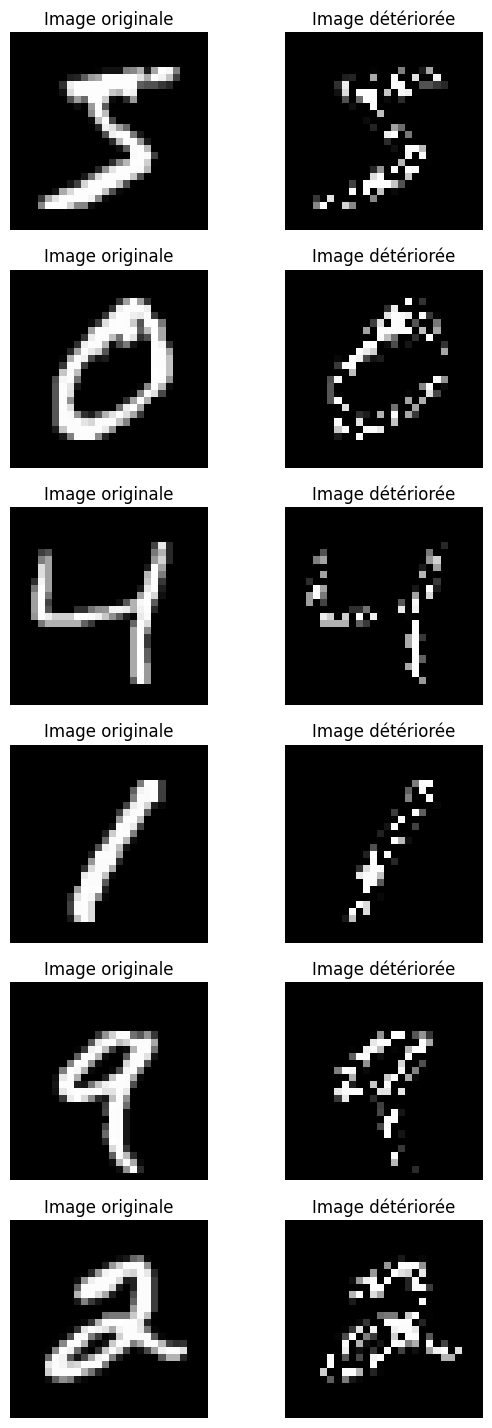

In [43]:
# TODO
plot_original_and_deteriorated_images(X_train_original[0:6], X_train_deteriorated[0:6])

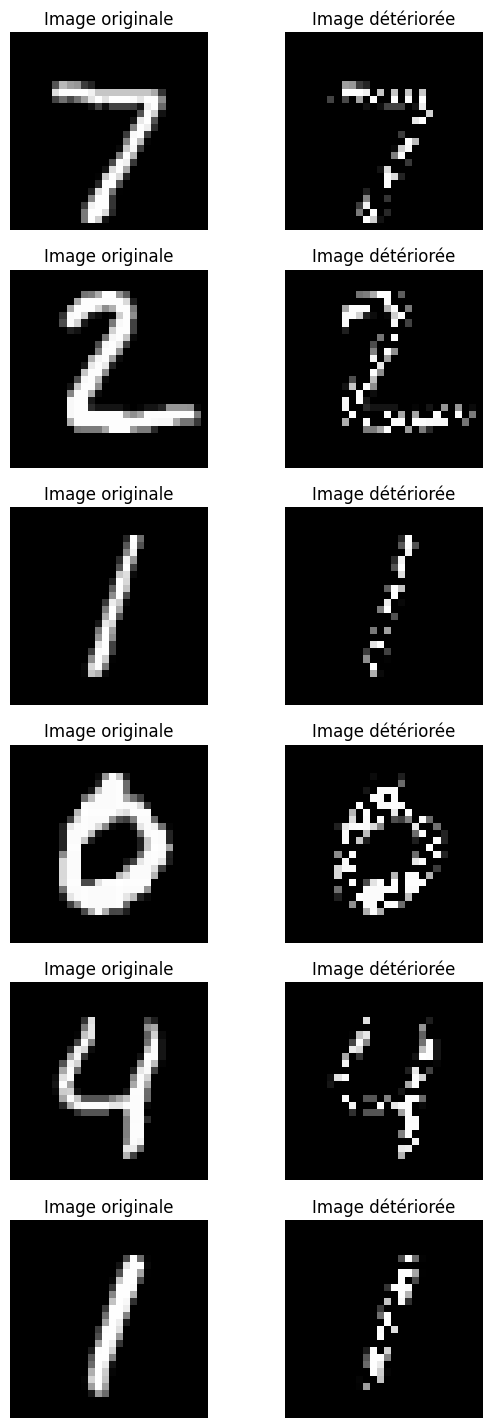

In [44]:
# TODO
plot_original_and_deteriorated_images(X_val_original[0:6], X_val_deteriorated[0:6])

Nous allons évaluer la performance des modèles avec l’erreur quadratique moyenne (*mean squared error*) :
$$
  \text{MSE} = \frac{1}{n H W} \sum_{i=1}^n \sum_{j=1}^H \sum_{k=1}^W \left( X_{i, j, k} - \hat{X}_{i, j, k} \right)^2
$$
où $n$ est le nombre d'images, $H$ est la hauteur (c'est-à-dire le nombre de lignes) et $W$ est la largeur (c'est-à-dire le nombre de colonnes).


Un modèle vraiment trivial consiste à ne prédire que des images noires (c'est-à-dire dont tous les pixels sont égaux à $0.0$) :
$$
    \forall i, j, k, \; \hat{X}_{i, j, k} = 0.0
$$

### Question 5

Calculez les erreurs quadratiques moyennes sur les jeux d'entraînement et de validation pour cette approche. On rappelle que :

* l'opérateur *puissance* en Python s'obtient avec deux étoiles : `2.0 ** 3` veut dire $2.0^3$ ; cet opérateur fonctionne également sur les tenseurs et applique la puissance à chaque élément du tenseur ;
* on peut calculer la valeur moyenne d'un tenseur avec la méthode [`torch.Tensor.mean()`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.mean.html) ou la fonction [`torch.mean()`](https://docs.pytorch.org/docs/stable/generated/torch.mean.html).

In [50]:
# TODO
def mean_squarred_error (x, x_bar) :
  mse = torch.mean((x - x_bar)**2)
  return float(mse)


In [57]:
# TODO
print("MSE modèle trivial simple sur le jeu d'entrainement = ", mean_squarred_error(X_train_original, 0))
print("MSE modèle trivial simple sur le jeu d'évaluation = ", mean_squarred_error(X_val_original, 0))

MSE modèle trivial simple sur le jeu d'entrainement =  0.11200257390737534
MSE modèle trivial simple sur le jeu d'évaluation =  0.11395809799432755


Un autre modèle trivial consiste à garder les images détériorées telles quelles.

### Question 6

Calculez les erreurs quadratiques moyennes sur les jeux d'entraînement et de validation pour cette approche.

In [59]:
# TODO
print("MSE modèle trivial image détérioré sur le jeu d'entrainement = ", mean_squarred_error(X_train_original, X_train_deteriorated))
print("MSE modèle trivial image détérioré sur le jeu d'évaluation = ", mean_squarred_error(X_val_original, X_val_deteriorated))

MSE modèle trivial image détérioré sur le jeu d'entrainement =  0.05598871037364006
MSE modèle trivial image détérioré sur le jeu d'évaluation =  0.05701133608818054


Avant d'entraîner un réseau de neurones, nous allons essayons une approche simple.
Nous allons utiliser un noyau de floutage uniforme : on remplace la valeur de chaque pixel par la moyenne uniforme de son pixel et de ses pixels voisins.
La fonction `box_blur_convolution()` définie ci-dessous implémente cette approche.

In [52]:
def box_blur_convolution(images_deteriorated, kernel_size=3):
    """

    Parameters
    ----------
    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.

    kernel_size : int, default = 3
        Taille du noyau. Doit être un entier impair supérieur ou égal à 3.

    Returns
    -------
    images_convolved : Tensor, shape = (n_images, 1, hauteur, largeur)

    """
    if not (isinstance(kernel_size, int) and (kernel_size > 2) and (kernel_size % 2 == 1)):
        raise ValueError("'kernel_size' doit être un entier impair supérieur ou égal à 3.")

    kernel = torch.ones(1, 1, kernel_size, kernel_size) / kernel_size ** 2
    conv = torch.nn.Conv2d(1, 1, kernel_size, padding="same", bias=False)
    conv.weight = torch.nn.Parameter(kernel, requires_grad=False)
    images_convolved = conv(images_deteriorated)
    return images_convolved

On appelle cette fonction pour appliquer la transformation sur les jeux d'entraînement et de validation :

In [53]:
X_train_reconstructed = box_blur_convolution(X_train_deteriorated)
X_val_reconstructed = box_blur_convolution(X_val_deteriorated)

### Question 7

Calculez les erreurs quadratiques moyennes sur ces deux jeux.

In [60]:
# TODO
print("MSE modèle trivial image reconstruite sur le jeu d'entrainement = ", mean_squarred_error(X_train_original, X_train_reconstructed))
print("MSE modèle trivial image reconstruite sur le jeu d'évaluation = ", mean_squarred_error(X_val_original, X_val_reconstructed))

MSE modèle trivial image reconstruite sur le jeu d'entrainement =  0.04470296576619148
MSE modèle trivial image reconstruite sur le jeu d'évaluation =  0.04515676945447922


On définit la fonction `plot_original_deteriorated_reconstructed_images()` pour afficher des images originales, des images détériorées et des images reconstruites.

In [61]:
def plot_original_deteriorated_reconstructed_images(
    images_original, images_deteriorated, images_reconstructed
):
    """Affiche les images originales, les images détériorées et les images reconstruites.

    Parameters
    ----------
    images_original : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.

    images_reconstructed : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images reconstruites.
    """
    # Récupère le nombre d'images
    n_images = images_original.shape[0]

    # Initialise la figure
    plt.figure(figsize=(6.5, 3 * n_images))

    # Pour chaque ligne
    for row in range(n_images):

        # Affiche l'image originale
        plt.subplot(n_images, 3, 1 + row * 3)
        plt.imshow(images_original[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image originale")
        plt.axis("off");

        # Affiche l'image détériorée
        plt.subplot(n_images, 3, 2 + row * 3)
        plt.imshow(images_deteriorated[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image détériorée")
        plt.axis("off");

        # Affiche l'image reconstruite
        plt.subplot(n_images, 3, 3 + row * 3)
        plt.imshow(images_reconstructed[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image reconstruite")
        plt.axis("off");

### Question 8

Appelez la fonction `plot_original_deteriorated_reconstructed_images()` pour afficher des images originales, des images détériorées et des images reconstruites sur le jeu de validation. Que constatez-vous ?

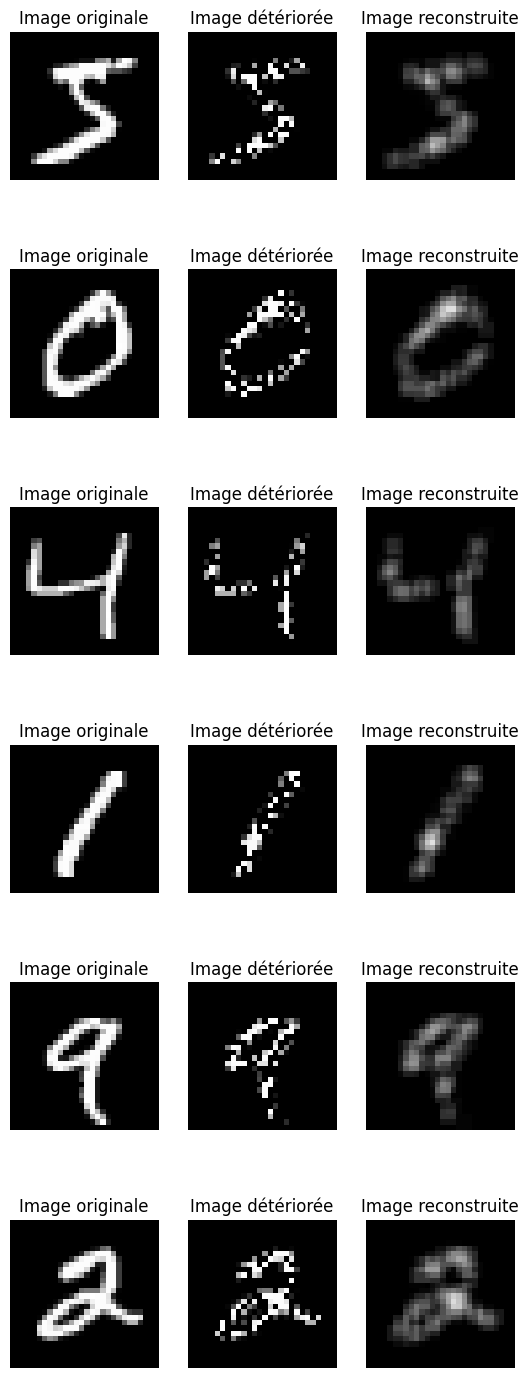

In [62]:
# TODO
plot_original_deteriorated_reconstructed_images(X_train_original[0:6],X_train_deteriorated[0:6],X_train_reconstructed[0:6])

**Réponse** : Sur l'image détériorée on observe bien qu'on a retiré des pixels blancs aléatoirement, notre fonction a donc bien marché. Les chiffres deviennent difficillement discernables. On observe que l'image reconstruite est floutée, mais se rapproche bien de l'image originale on pourrait deviner le chiffre, néanmoins le chiffre n'est clairement pas aussi facilement discernable que l'original.

### Question 9

Pour confirmer votre réponse à la question précédente, affichez la distribution des pixels des images originales d'une part et des images reconstruites d'autre part, sur le jeu d'entraînement.
Vous pouvez utiliser la fonction [`matplotlib.pyplot.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

(array([593.,  59.,  39.,  33.,  22.,  21.,   4.,   6.,   5.,   2.]),
 array([0.        , 0.07324618, 0.14649236, 0.21973854, 0.29298472,
        0.36623091, 0.43947709, 0.51272327, 0.58596945, 0.65921563,
        0.73246181]),
 <BarContainer object of 10 artists>)

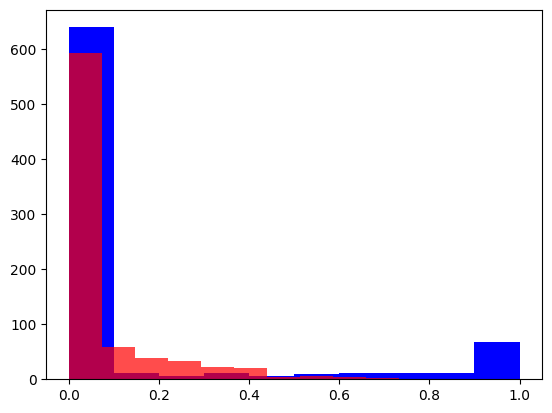

In [78]:
# TODO
pixels_x_train_original = X_train_original[0].flatten().numpy()
pixels_x_train_reconstructed = X_train_reconstructed[0].flatten().numpy()
plt.hist(pixels_x_train_original, color = "blue")
plt.hist(pixels_x_train_reconstructed, color = "red", alpha = 0.7)

Pour essayer de remédier à ce problème, nous allons normaliser les images pour que la valeur maximale des pixels de chaque image reconstruite soit égale à $1.0$. Pour ce faire, on va simplement diviser chaque pixel d'une image reconstruite par la valeur maximale des pixels de cette image reconsruite.

### Question 10

1. Appliquez cette transformation aux images reconstruites des jeux d'entraînement et d'évaluation.
2. Affichez la nouvelle distribution des pixels sur le jeu d'entraînement.
3. Affichez quelques images reconstruites normalisées sur le jeu de validation avec la fonction `plot_original_deteriorated_reconstructed_images()`.
4. Calculez les erreurs quadratiques moyennes sur les deux jeux.
5. Commentez les résultats obtenus.

Pour répondre à la première question, vous pouvez utiliser la fonction [`torch.amax()`](https://docs.pytorch.org/docs/stable/generated/torch.amax.html) ou la méthode [`torch.Tensor.amax()`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.amax.html).
Lisez la documentation, notamment pour les paramètres `dim` et `keepdim`.
Il est possible de répondre à la question sans boucle `for` grâce au [*broadcasting*](https://docs.pytorch.org/docs/stable/notes/broadcasting.html).

In [80]:
# TODO
X_train_reconstructed_normalized = X_train_reconstructed / torch.amax(X_train_reconstructed, dim=(1,2,3), keepdim=True)
X_val_reconstructed_normalized = X_val_reconstructed / torch.amax(X_val_reconstructed, dim=(1,2,3), keepdim=True)

<function matplotlib.pyplot.show(close=None, block=None)>

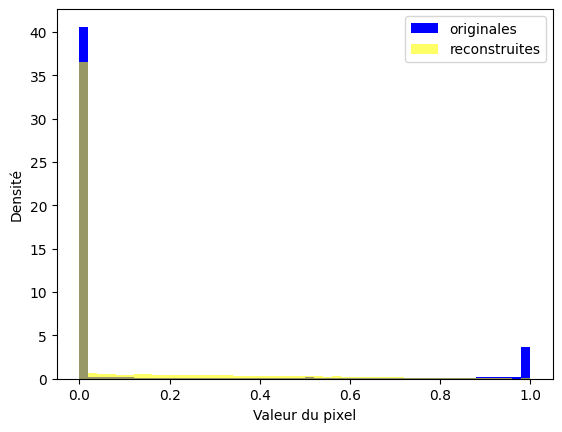

In [91]:
# TODO
import matplotlib.pyplot as plt
import numpy as np

pixel_original = X_train_original.ravel()
pixel_reconstructed = X_val_reconstructed_normalized.ravel()


plt.hist(pixel_original, bins=50, alpha=1, label="originales", color="blue", density=True)
plt.hist(pixel_reconstructed, bins=50, alpha=0.6, label="reconstruites", color="yellow", density=True)
plt.xlabel("Valeur du pixel")
plt.ylabel("Densité")
plt.legend()
plt.show

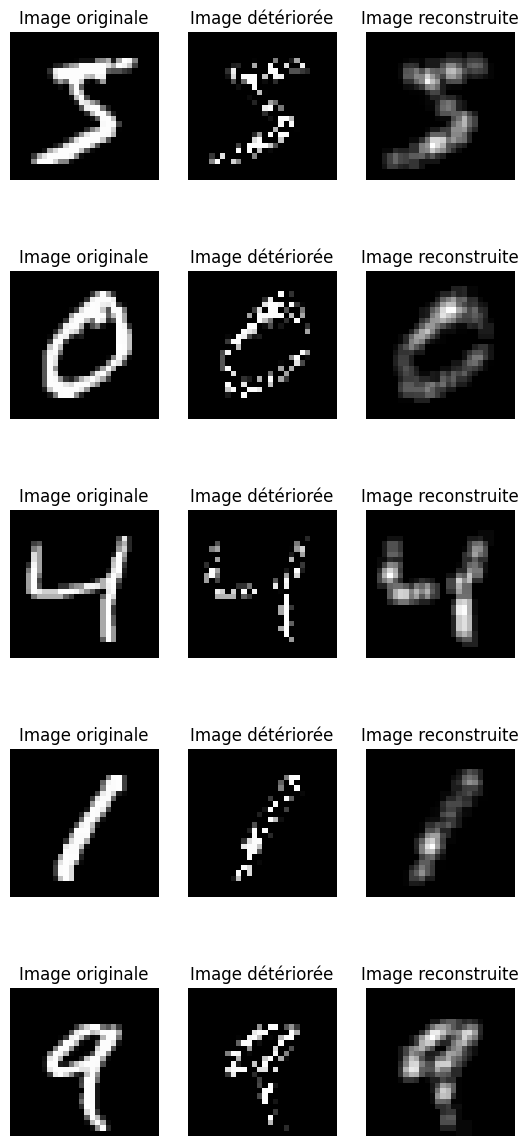

In [92]:
# TODO
plot_original_deteriorated_reconstructed_images(X_train_original[:5], X_train_deteriorated[:5], X_train_reconstructed_normalized[:5])

In [94]:
# TODO
print("erreur quadratique train reconstruit normalisé", mean_squarred_error(X_train_original, X_train_reconstructed_normalized))
print("erreur quadratique val reconstruit normalisé", mean_squarred_error(X_val_original, X_val_reconstructed_normalized))

erreur quadratique train reconstruit normalisé 0.03152918443083763
erreur quadratique val reconstruit normalisé 0.03194475919008255


**Réponse** : Les résultats sont meilleurs avec une MSE qui se rapproche de 0 cependant les images reconstruites restent tout de même floues et pas totaltement reconstruites.

Nous allons maintenant essayer une autre approche un peu plus avancée pour rendre la distribution des pixels des images reconstruites plus proche de celles des pixels des images originales.
Pour cela, nous allons utiliser la **transformation par quantiles**.

Sur le jeu d'entraînement, on apprend :
* $T_1$ : la transformation qui passe de la distribution des pixels des images originales à une distribution uniforme, et
* $T_2$ : la transformation qui passe de la distribution des pixels des images reconstruites à une distribution uniforme.

Ensuite, pour transformer les images reconstruites afin que la distribution de leurs pixels suive la distribution des pixels des images originales, on applique la transformation $T_1^{-1} \circ T_2$ aux images reconstruites.

Le code ci-dessous applique ces transformations sur les jeux d'entraînement et d'évaluation :

In [107]:
from sklearn.preprocessing import QuantileTransformer


qt_train_original = QuantileTransformer(n_quantiles=100, subsample=None)
qt_train_reconstructed = QuantileTransformer(n_quantiles=100, subsample=None)

qt_train_original.fit(X_train_original.ravel().view(-1, 1))
qt_train_reconstructed.fit(X_train_reconstructed.ravel().view(-1, 1))

X_train_reconstructed_quantile = qt_train_original.inverse_transform(
    qt_train_reconstructed.transform(X_train_reconstructed.ravel().view(-1, 1))
).reshape(X_train_reconstructed.shape)

X_val_reconstructed_quantile = qt_train_original.inverse_transform(
    qt_train_reconstructed.transform(X_val_reconstructed.ravel().view(-1, 1))
).reshape(X_val_reconstructed.shape)

### Question 11

1. Affichez la nouvelle distribution des pixels sur le jeu d'entraînement.
2. Affichez quelques images reconstruites transformées sur le jeu de validation avec la fonction `plot_original_deteriorated_reconstructed_images()`.
3. Calculez les erreurs quadratiques moyennes sur les deux jeux.
4. Commentez les résultats obtenus.

<function matplotlib.pyplot.show(close=None, block=None)>

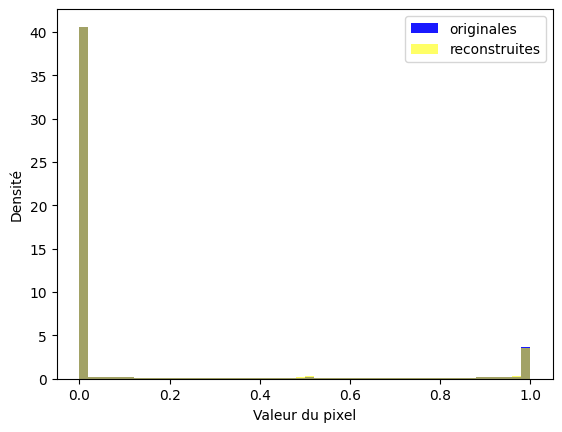

In [108]:
# TODO
pixel_original = X_train_original.ravel()
pixel_reconstructed = X_train_reconstructed_quantile.ravel()


plt.hist(pixel_original, bins=50, alpha=0.9, label="originales", color="blue", density=True)
plt.hist(pixel_reconstructed, bins=50, alpha=0.6, label="reconstruites", color="yellow", density=True)
plt.xlabel("Valeur du pixel")
plt.ylabel("Densité")
plt.legend()
plt.show

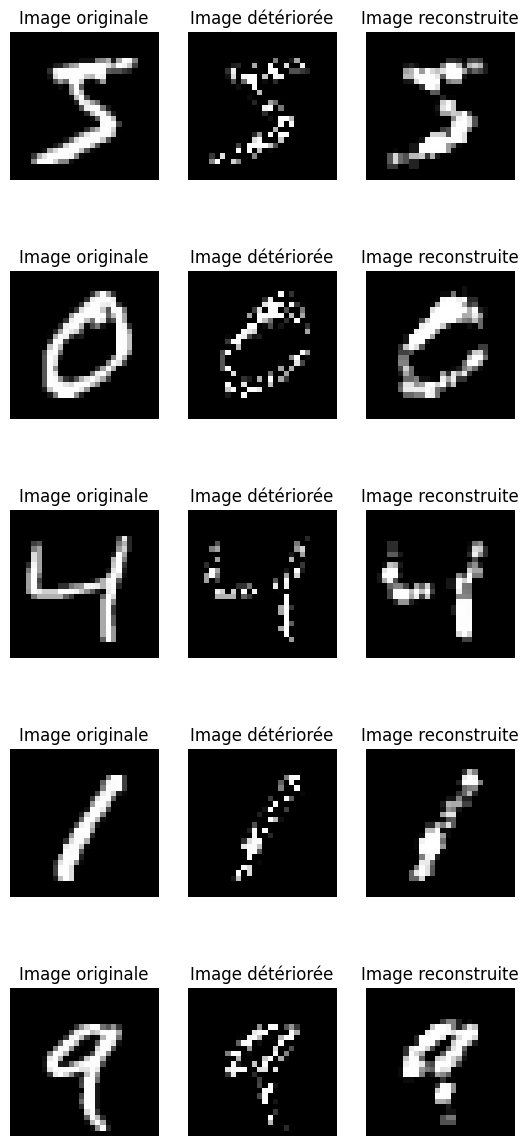

In [109]:
# TODO
plot_original_deteriorated_reconstructed_images(X_train_original[:5], X_train_deteriorated[:5], X_train_reconstructed_quantile[:5])

In [110]:
# TODO
print("mse train reconstruit quantile :",mean_squarred_error(X_train_original, X_train_reconstructed_quantile))
print("mse val reconstruit quantile :",mean_squarred_error(X_val_original, X_val_reconstructed_quantile))

/tmp/ipython-input-1035630328.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.mean((x - x_bar)**2)


mse train reconstruit quantile : 0.026425307597846098
mse val reconstruit quantile : 0.0263102850880625


**Réponse** : La mse s'améliore encore, la densité des reconstruit est proche des originales. Les images reste encore un peu flou et pas totalement reconstruites

Nous allons maintenant essayer une approche par réseaux de neurones convolutifs.

### Question 12

Créez les *dataloaders* pour les jeux d'entraînement et de validation en utilisant la classe [`torch.utils.data.DataLoader()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) avec des lots de taille $32$. N'oubliez pas de mélanger (*shuffle*) les observations pour le jeu d'entraînement, mais pas pour le jeu de validation. Pour créer les jeux de données, utiliser la classe [`torch.utils.data.TensorDataset()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset). **Chaque jeu de données doit contenir à la fois les images détériorées et les images originales**.

In [111]:
from torch.utils.data import DataLoader, TensorDataset

dataset_train = TensorDataset(X_train_deteriorated, X_train_original)
dataset_val = TensorDataset(X_val_deteriorated, X_val_original)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32)

## Architecture

Nous allons utiliser une architecture de type auto-encodeur, composée d'un encodeur et d'un décodeur.

L'encodeur aura l'architecture séquentielle suivante :

* Convolution en deux dimensions avec $32$ canaux en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.
* Convolution en deux dimensions avec $16$ canaux en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.
* Convolution en deux dimensions avec $8$ canaux en sorties, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.

Le décodeur aura l'architecture séquentielle suivante :

* Convolution transposée avec $8$ canaux en sortie, un noyau de taille $3 \times 3$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution transposée avec $16$ canaux en sortie, un noyau de taille $2 \times 2$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution transposée avec $32$ canaux en sortie, un noyau de taille $2 \times 2$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution avec $1$ canal en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation sigmoïde.

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html),
[`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html),
[`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html),
[`torch.nn.ConvTranspose2d()`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) et
[`torch.nn.Sigmoid()`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html).

        
### Question 13

Complétez le code manquant dans les méthodes `__init__()`, `forward()`, `step()` et `configure_optimizers()` de la classe `DenoisingAutoencoder()` avec les informations suivantes :
* `__init__()` : il faut définir la fonction de perte (`self.loss`) : on utilisera l'erreur quadratique moyenne ; il faut initialiser toutes les couches.
* `forward()` : il faut définir la passe avant, c'est-à-dire comment passer des entrées (les images détériorées) aux sorties (les images reconstruites).
* `step()` : étant donné un lot d'observations (`batch`), il faut :
    + récupérer les entrées (les images détériorées) et les vraies sorties (les images originales),
    + faire une passe avant pour récupérer les images reconstruites,
    + calculer la fonction de coût entre les images reconstruites et les images originales (`loss`).
* `configure_optimizers()` : on utilisera l'algorithme d'optimisation *Adam* avec les valeurs par défaut pour ses hyperparamètres.

In [1]:
import lightning as L


class DenoisingAutoencoder(L.LightningModule):

    def __init__(self):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        # Initialisation de la fonction de perte
        self.loss = torch.nn.MSELoss()

        # Initialisation de toutes les couches
        self.sequential = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 16, kernel_size = 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 8, kernel_size = 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.ConvTranspose2d(8, 8, kernel_size=3, stride = 2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, kernel_size=2, stride = 2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 32, kernel_size=2, stride = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 1, kernel_size = 3, padding=1),
            torch.nn.Sigmoid()
        )
        #### END TODO ####

    def forward(self, X_deteriorated):
        """Passe avant

        Parameters
        ----------
        X_deteriorated : Tensor, shape = (taille_lot, 1, hauteur, largeur)
            Images détériorées.

        Returns
        -------
        X_predicted : Tensor, shape = (taille_lot, 1, hauteur, largeur)
            Images prédites.
        """
        ### BEGIN TODO ###
        X_predicted = self.sequential(X_deteriorated)

        #### END TODO ####
        return X_predicted

    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'images (l'argument X)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : list[Tensor]
            Lot d'observations.

        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        ### BEGIN TODO ###
        X, y = batch
        y_pred = self(X)
        loss = self.loss(y_pred, y)

        #### END TODO ###

        if dataset == "training":
            name = "train"
            bar_step = True
        else:
            name = "val"
            bar_step = False

        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------
            |     Jeu      | Fonction de perte |
            | ------------ | ----------------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|
            ------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, '\n')

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        ### BEGIN TODO ###
        optimizer = torch.optim.Adam(self.parameters())
        #### END TODO ####
        return optimizer

ModuleNotFoundError: No module named 'lightning'

### Question 14

Affichez un résumé de votre architecture. Combien de paramètres entraînables a-t-elle ?

In [113]:
# TODO
from torchinfo import summary
model = DenoisingAutoencoder()
summary(model,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
DenoisingAutoencoder                     [1, 28, 28]               --
├─Sequential: 1-1                        [1, 28, 28]               --
│    └─Conv2d: 2-1                       [32, 28, 28]              320
│    └─ReLU: 2-2                         [32, 28, 28]              --
│    └─MaxPool2d: 2-3                    [32, 14, 14]              --
│    └─Conv2d: 2-4                       [16, 14, 14]              4,624
│    └─ReLU: 2-5                         [16, 14, 14]              --
│    └─MaxPool2d: 2-6                    [16, 7, 7]                --
│    └─Conv2d: 2-7                       [8, 7, 7]                 1,160
│    └─ReLU: 2-8                         [8, 7, 7]                 --
│    └─MaxPool2d: 2-9                    [8, 3, 3]                 --
│    └─ConvTranspose2d: 2-10             [8, 7, 7]                 584
│    └─ReLU: 2-11                        [8, 7, 7]                 --
│    └─

**Réponse** : Le paramètre a 9,585 paramèrtres entrainables

### Question 15

Entraînez votre modèle pendant $10$ époques.

In [114]:
# TODO
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model = DenoisingAutoencoder()

trainer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer.fit(
    model=model,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |          | 0/? [00:00<?, ?it/s]

Version 0



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 1 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.03369      |
|  Validation  |      0.02501      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 2 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.02346      |
|  Validation  |      0.02161      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 3 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.02118      |
|  Validation  |      0.02008      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 4 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01988      |
|  Validation  |      0.01887      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 5 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01884      |
|  Validation  |      0.01856      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 6 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01802      |
|  Validation  |      0.01750      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 7 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01727      |
|  Validation  |      0.01675      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 8 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01665      |
|  Validation  |      0.01617      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 9 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01617      |
|  Validation  |      0.01555      |
------------------------------------ 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 10 / 10
------------------------------------
|     Jeu      | Fonction de perte |
| ------------ | ----------------- |
| Entraînement |      0.01566      |
|  Validation  |      0.01549      |
------------------------------------ 



On récupère toutes les images reconstruites par le réseau de neurones artificiels sur le jeu de validation :

In [ ]:
X_val_reconstructed_dae = model(X_val_deteriorated).detach()

### Question 16

En utilisant la fonction `plot_original_deteriorated_reconstructed_images()`, affichez quelques images reconstruites par le réseau de neurones artificiels sur le jeu de validation.

In [ ]:
# TODO

### Question 17

Quel est le meilleur modèle parmi les différentes approches essayées ? Justifiez votre réponse.

**Réponse** : TODO